In [1]:
# 模型训练
import numpy as np
import pandas as pd
import os
import tqdm
import datetime
import time

base_path = 'stock/stock'

market_map = {'主板':0, '中小板':1}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16, 
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24, 
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6, 
 '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13, 
 'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20, 
 '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
 '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
 '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44, 
 '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52, 
 '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60, 
 '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68, 
 '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77, 
 '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85, 
 '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
 '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102, 
 '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

In [2]:
def JudgeST(x):
    if 'ST' in x:
        return 1
    else:
        return 0

def GetMA(df, col_name, rolling_day):
    tmp_array = df[col_name].values.reshape(-1)
    df.loc[ rolling_day:, col_name + '_'+str(rolling_day)] = (tmp_array[0:-rolling_day] - 
                                                              tmp_array[rolling_day:]) / tmp_array[0:-rolling_day]
    return df

col = ['ma'+str(i) for i in [5, 10, 13, 21, 30]] + ['ma_v_'+str(i) for i in [5, 10, 13, 21, 30]]

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'), encoding='ANSI')
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(['index', 'symbol', 'fullname'], axis=1, inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)


# 读取指数信息
stock_index_info = pd.DataFrame()
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH_NormalData.csv'))
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
for ts_code in tqdm.tqdm(company_info['ts_code']):
    try:
        tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    except:
        continue
        pass
    # 还需要去除一些停牌时间很久的企业，后期加
    if len(tmp_df) < 100:  # 去除一些上市不久的企业
        remove_stock.append(ts_code)
        continue
    tmp_df['amp']= (tmp_df['high']-tmp_df['low'])/(tmp_df.shift(1)['close'])
    tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index(drop=True)    
    for tmp_col in col:
        for rolling_day in [5]:
            tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
    tmp_list.append(tmp_df)
    
stock_info = pd.concat(tmp_list)
stock_info = stock_info.reset_index(drop=True)
ts_code_map = dict(zip(list(company_info['ts_code']), range(len(company_info))))


stock_info = stock_info.reset_index(drop=True)
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)

stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
stock_info['ts_date_id'] = (10000 + stock_info['ts_code_id']) * 10000 + stock_info['trade_date_id']
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

100%|██████████| 3130/3130 [00:56<00:00, 55.65it/s]


In [3]:
stock_info = stock_info.drop_duplicates(subset=['ts_date_id'])
print(len(stock_info), len(stock_info_copy))

2749209 2749209


In [4]:
feature_col = []

In [5]:
#涨为1，跌为-1
stock_info['flag'] = stock_info['close'] > stock_info['open']
stock_info['flag'] = stock_info['flag'] * 2 - 1
stock_info['my_vol'] = stock_info['flag'] * stock_info['vol']
#形成涨为流入数（+），跌为流出数（-）的形式

use_col = []
for i in range(21):
    print('begin shift %d days' % (i+1))
    tmp_df = stock_info[['ts_date_id', 'my_vol']]
    tmp_df = tmp_df.rename(columns={'my_vol':'my_vol_shift_{}'.format(i+1)})
    use_col.append('my_vol_shift_{}'.format(i+1))
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')

stock_info.dropna(inplace=True)

#算出该只股票3，5，10，13，21天内的净成交流入值
for rolling_day in [3, 5, 10, 13, 21]:
    stock_info['my_vol_mv_' + str(rolling_day)] = np.sum(stock_info[use_col[0:rolling_day]].values, axis=1)

feature_col = []   
for rolling_day in [3, 5, 10, 13, 21]:
    stock_info['my_vol_mv_' + str(rolling_day)] = \
        stock_info['my_vol_mv_' + str(rolling_day)] / stock_info['ma_v_13'] / 10
    feature_col.append('my_vol_mv_' + str(rolling_day))  

begin shift 1 days
begin shift 2 days
begin shift 3 days
begin shift 4 days
begin shift 5 days
begin shift 6 days
begin shift 7 days
begin shift 8 days
begin shift 9 days
begin shift 10 days
begin shift 11 days
begin shift 12 days
begin shift 13 days
begin shift 14 days
begin shift 15 days
begin shift 16 days
begin shift 17 days
begin shift 18 days
begin shift 19 days
begin shift 20 days
begin shift 21 days


In [7]:
feature_test = []
feature_test = feature_col + ['ts_code', 'trade_date', 'ts_date_id']
feature_test_info = stock_info[feature_test]

In [8]:
label_test_path = os.path.join('stock/stock','label_2', 'label.csv')
label_test = pd.read_csv(label_test_path)

In [9]:
label_test = label_test.merge(feature_test_info, how='left', on=['ts_code', 'ts_date_id', 'trade_date'])
label_test.dropna(inplace=True)

In [11]:
label_test.columns

Index(['ts_code', 'open', 'trade_date', 'ts_date_id', 'label_max', 'label_min',
       'label_final', 'my_vol_mv_3', 'my_vol_mv_5', 'my_vol_mv_10',
       'my_vol_mv_13', 'my_vol_mv_21'],
      dtype='object')

In [16]:
import os
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

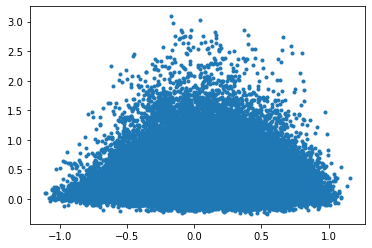

In [17]:
plt.figure()
plt.plot(np.array(label_test['my_vol_mv_5']), np.array(label_test['label_max']), '.')
plt.show()
#纵轴为最大收益率，横轴为五天净流入量

In [19]:
def split(x):   
    return int(x / 0.1)
label_test['my_vol_mv_5_split'] = label_test['my_vol_mv_5'].apply(split)
idx = label_test['my_vol_mv_5_split'] > 10
label_test.loc[idx, 'my_vol_mv_5_split'] = 10

idx = label_test['my_vol_mv_5_split'] < -10
label_test.loc[idx, 'my_vol_mv_5_split'] = -10

In [20]:
tmp_list= [i-10 for i in range(21)]
tmp_array = []
for i in tmp_list:
    tmp_df = label_test[label_test['my_vol_mv_5_split'] == i]
    tmp_array.append(np.array(tmp_df['label_max']))

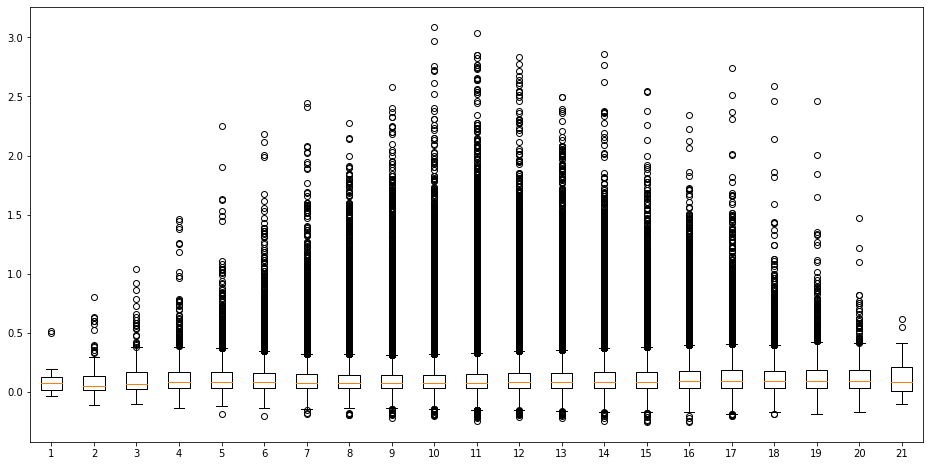

In [22]:
plt.figure(figsize=(16,8))
plt.boxplot(tmp_array)
# plt.title(str(i+10))
plt.show()
#得到箱型图，纵轴为最大收益，横轴为区间

In [ ]:
#开始分区

In [23]:
tmp_list= [i-10 for i in range(21)]
bins=[-5, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.3, 5]
list_ = []
for i in tmp_list:
    tmp_df = label_test[label_test['my_vol_mv_5_split'] == i]
    tmp_df['cate'] = pd.cut(tmp_df['label_max'], bins, labels=list(range(10)))
    tmp = tmp_df['cate'].value_counts(normalize=True)
    tmp2 = [tmp[i+1] for i in range(9)]
    list_.append(tmp2)
    # break
df = pd.DataFrame(list_)
df.columns=['-0.2,-0.1', '-1,-0.05','-0.05-0', '0-0.05', '0.05-0.1', '0.1-0.15',
            '0.15-0.2', '0.2-0.3', '0.3-']
df['my_vol_mv_5'] = np.array(tmp_list) * 0.1

<ipython-input-23-fff47a3b8282>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['cate'] = pd.cut(tmp_df['label_max'], bins, labels=list(range(10)))


In [24]:
df['>0.1'] = df['0.15-0.2'] + df['0.2-0.3'] + df['0.3-'] + df['0.1-0.15']
df['0-0.1'] = df['0-0.05'] + df['0.05-0.1']
df['>0'] = df['>0.1'] + df['0-0.1']

In [25]:
df
#比较净流入量和最大收益的关系：当其值较大时，最大收益超过0.1的股票也随之变多，可以看到在0.1之后，都超过了0.4的阈值

,"-0.2,-0.1","-1,-0.05",-0.05-0,0-0.05,0.05-0.1,0.1-0.15,0.15-0.2,0.2-0.3,0.3-,my_vol_mv_5,>0.1,0-0.1,>0
0,0.000000,0.000000,0.095238,0.285714,0.261905,0.142857,0.166667,0.000000,0.047619,-1.0,0.357143,0.547619,0.904762
1,0.012121,0.000000,0.109091,0.418182,0.139394,0.090909,0.084848,0.066667,0.078788,-0.9,0.321212,0.557576,0.878788
2,0.002146,0.008584,0.098712,0.302575,0.190987,0.122318,0.070815,0.124464,0.079399,-0.8,0.396996,0.493562,0.890558
3,0.002052,0.007524,0.077975,0.266758,0.214090,0.135431,0.103283,0.103283,0.089603,-0.7,0.431601,0.480848,0.912449
4,0.000893,0.001965,0.057531,0.261033,0.231910,0.155083,0.101840,0.110595,0.079150,-0.6,0.446668,0.492943,0.939611
5,0.000253,0.001768,0.053793,0.288716,0.231842,0.151480,0.097434,0.100970,0.073694,-0.5,0.423578,0.520558,0.944136
6,0.000395,0.002609,0.059008,0.307768,0.238622,0.148094,0.089343,0.087327,0.066834,-0.4,0.391597,0.546391,0.937988
7,0.000327,0.002354,0.062035,0.308460,0.240239,0.144982,0.089487,0.087310,0.064805,-0.3,0.386584,0.548699,0.935283
8,0.000324,0.002326,0.067707,0.311468,0.237952,0.144958,0.086794,0.085885,0.062582,-0.2,0.380219,0.549419,0.929638
9,0.000299,0.002664,0.070289,0.309985,0.235361,0.144162,0.087056,0.085852,0.064327,-0.1,0.381397,0.545346,0.926743


In [27]:
tmp_list= [i-10 for i in range(21)]
bins=[-5, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 5]
list_ = []
for i in tmp_list:
    tmp_df = label_test[label_test['my_vol_mv_5_split'] == i]
    tmp_df['cate'] = pd.cut(tmp_df['label_min'], bins, labels=list(range(8)))
    tmp = tmp_df['cate'].value_counts(normalize=True)
    tmp2 = [tmp[i+1] for i in range(7)]
    list_.append(tmp2)
    # break
df = pd.DataFrame(list_)
df.columns=['-0.2,-0.15', '-0.15,0.1', '-1,-0.05','-0.05-0', '0-0.05', '0.05-0.1', '0.1-']
df['my_vol_mv_5'] = np.array(tmp_list) * 0.1

<ipython-input-27-761d9e917d4c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['cate'] = pd.cut(tmp_df['label_min'], bins, labels=list(range(8)))


In [28]:
df['>-0.05'] = df['-0.05-0'] + df['0-0.05'] + df['0.05-0.1'] + df['0.1-']

In [29]:
df
#比较净流入量和最小收益率的关系：净流入量过大时，成交过于活跃，风险也大，不排除主力在放大成交量，压缩做空头的投机者的筹码的可能
#当净流入量过小时，筹码不断流出，自然导致股票跌幅较大，也有可能就是主力在砸价，打压

,"-0.2,-0.15","-0.15,0.1","-1,-0.05",-0.05-0,0-0.05,0.05-0.1,0.1-,my_vol_mv_5,>-0.05
0,0.190476,0.190476,0.380952,0.119048,0.023810,0.000000,0.000000,-1.0,0.142857
1,0.096970,0.212121,0.315152,0.224242,0.030303,0.012121,0.000000,-0.9,0.266667
2,0.092275,0.195279,0.276824,0.285408,0.047210,0.006438,0.000000,-0.8,0.339056
3,0.087551,0.137483,0.274966,0.343365,0.075239,0.006840,0.002052,-0.7,0.427497
4,0.064499,0.142398,0.278185,0.383062,0.071288,0.006611,0.001251,-0.6,0.462212
5,0.061370,0.137034,0.271644,0.398576,0.085514,0.005405,0.000859,-0.5,0.490353
6,0.066300,0.145011,0.277968,0.382270,0.078691,0.004486,0.000474,-0.4,0.465921
7,0.072027,0.151248,0.280991,0.368177,0.075735,0.004469,0.000619,-0.3,0.449000
8,0.075829,0.156557,0.286478,0.356565,0.067712,0.004342,0.000661,-0.2,0.429280
9,0.080000,0.160498,0.290409,0.340313,0.065021,0.004228,0.000734,-0.1,0.410296


In [30]:
tmp_list= [i-10 for i in range(21)]

list_ = []
for i in tmp_list:
    tmp_df = label_test[label_test['my_vol_mv_5_split'] == i]
    tmp = tmp_df['label_final'].value_counts(normalize=True)
    tmp2 = [tmp[i] for i in range(2)]
    list_.append(tmp2)
df = pd.DataFrame(list_)
df['my_vol_mv_5'] = np.array(tmp_list) * 0.1

In [31]:
df
#比较净流入量和标签的关系，在0.1-0.6的区间内，可以看到标签1的比例是在逐渐上升

,0,1,my_vol_mv_5
0,0.785714,0.214286,-1.0
1,0.775758,0.224242,-0.9
2,0.753219,0.246781,-0.8
3,0.706566,0.293434,-0.7
4,0.698410,0.301590,-0.6
5,0.709264,0.290736,-0.5
6,0.730135,0.269865,-0.4
7,0.731301,0.268699,-0.3
8,0.739709,0.260291,-0.2
9,0.738989,0.261011,-0.1


In [33]:
# 获取月份 和 星期几
def get_weekday(x):
    x = str(x)
    return datetime.datetime.fromtimestamp(time.mktime(time.strptime(x, "%Y%m%d"))).weekday()
stock_info['month'] = stock_info['trade_date'].apply(lambda x: int(str(x)[4:6]))
stock_info['weekday'] = stock_info['trade_date'].apply(get_weekday)
feature_col.append('month')
feature_col.append('weekday')

In [34]:
# 求相对的成交量 这里与10均线比较
stock_info['vol'] = (stock_info['vol'] - stock_info['ma_v_10']) / stock_info['ma_v_10']
feature_col.append('vol')

#转换low colse等同为相对指标
col = ['open', 'high', 'low', 'high', 'pre_close']
for tmp_col in col:
    stock_info[tmp_col+'_transform'] = (stock_info[tmp_col] - stock_info['ma10']) / stock_info['ma10']
    feature_col.append(tmp_col+'_transform')

In [35]:
# 添加大盘指数信息
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
for tmp_col in ['amount', 'pre_close']:
    tmp_df = tmp_df.rename(columns={tmp_col: tmp_col + '_index_000001'})
    stock_info = stock_info.merge(tmp_df[['trade_date', tmp_col + '_index_000001']], on='trade_date', how='left')

#添加上证指数前五天信息与其昨日比较信息（成交额和收盘价），可以剖析大盘趋势
for tmp_col in ['amount_index_000001', 'pre_close_index_000001', 'amount', 'pre_close']:
    print(tmp_col)
    for i in range(5):
        tmp_df = stock_info[['ts_date_id', tmp_col]]
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        tmp_df = tmp_df.rename(columns={tmp_col:new_col_name})
        feature_col.append(new_col_name)
        tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
        stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
    for i in range(5):
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        stock_info[new_col_name] = (stock_info[tmp_col] - stock_info[new_col_name]) / stock_info[new_col_name]

amount_index_000001
pre_close_index_000001
amount
pre_close


In [36]:
#添加换手率特征
feature_col.append('turnover_rate')

In [37]:
#添加振幅特征
feature_col.append('amp')

In [48]:
print(stock_info.columns)


Index(['ts_code_x', 'trade_date_x', 'open_x', 'ts_date_id', 'label_final',
       'trade_date_y', 'ts_code_y', 'open_y', 'high', 'low',
       ...
       'amount_shift_1', 'amount_shift_2', 'amount_shift_3', 'amount_shift_4',
       'amount_shift_5', 'pre_close_shift_1', 'pre_close_shift_2',
       'pre_close_shift_3', 'pre_close_shift_4', 'pre_close_shift_5'],
      dtype='object', length=109)


In [39]:
feature_col

['my_vol_mv_3',
 'my_vol_mv_5',
 'my_vol_mv_10',
 'my_vol_mv_13',
 'my_vol_mv_21',
 'month',
 'weekday',
 'vol',
 'open_transform',
 'high_transform',
 'low_transform',
 'high_transform',
 'pre_close_transform',
 'amount_index_000001_shift_1',
 'amount_index_000001_shift_2',
 'amount_index_000001_shift_3',
 'amount_index_000001_shift_4',
 'amount_index_000001_shift_5',
 'pre_close_index_000001_shift_1',
 'pre_close_index_000001_shift_2',
 'pre_close_index_000001_shift_3',
 'pre_close_index_000001_shift_4',
 'pre_close_index_000001_shift_5',
 'amount_shift_1',
 'amount_shift_2',
 'amount_shift_3',
 'amount_shift_4',
 'amount_shift_5',
 'pre_close_shift_1',
 'pre_close_shift_2',
 'pre_close_shift_3',
 'pre_close_shift_4',
 'pre_close_shift_5',
 'turnover_rate',
 'amp']

In [83]:
feature_col.remove('month')
feature_col

ValueError: list.remove(x): x not in list

In [40]:
stock_info['ts_date_id'] = stock_info['ts_date_id'] + 1

In [41]:
label_path = os.path.join('stock/stock','label', 'label.csv')
label = pd.read_csv(label_path)
label = label[['ts_code', 'trade_date', 'open', 'ts_date_id', 'label_final']]

In [43]:
#stock_info.drop(['open', 'trade_date', 'ts_code'], axis=1, inplace=True)
stock_info = label.merge(stock_info, on='ts_date_id', how='left')
stock_info.dropna(inplace=True)

In [44]:
stock_info = stock_info.reset_index(drop=True)
print(len(stock_info))

2195040


In [45]:
stock_info.head()

,ts_code_x,trade_date_x,open_x,ts_date_id,label_final,trade_date_y,ts_code_y,open_y,high,low,...,amount_shift_1,amount_shift_2,amount_shift_3,amount_shift_4,amount_shift_5,pre_close_shift_1,pre_close_shift_2,pre_close_shift_3,pre_close_shift_4,pre_close_shift_5
0,000001.SZ,20180710,8.5677,100000125,0,20180709.0,000001.SZ,8.2543,8.5772,8.2448,...,0.472890,0.737830,1.033130,0.144394,0.083261,0.006978,0.005808,-0.001154,0.005808,-0.047300
1,000001.SZ,20180711,8.3208,100000126,0,20180710.0,000001.SZ,8.5677,8.5677,8.4442,...,-0.360132,-0.057545,0.111981,0.300934,-0.267739,0.042719,0.049995,0.048775,0.041516,0.048775
2,000001.SZ,20180712,8.3011,100000127,0,20180711.0,000001.SZ,8.3208,8.3872,8.2448,...,-0.072566,-0.406565,-0.125935,0.031289,0.206531,-0.005538,0.036945,0.044180,0.042967,0.035749
3,000001.SZ,20180713,8.6100,100000128,0,20180712.0,000001.SZ,8.3011,8.6582,8.2818,...,0.354330,0.256052,-0.196293,0.183772,0.396706,-0.022275,-0.027690,0.013847,0.020921,0.019735
4,000001.SZ,20180716,8.5424,100000129,0,20180713.0,000001.SZ,8.6100,8.6293,8.5134,...,-0.469195,-0.281115,-0.333281,-0.573388,-0.371648,0.027783,0.004889,-0.000676,0.042014,0.049285


In [82]:

trn_col = feature_col
# 'high', 'low', 'close', 'pre_close',
trn_col = list(set(trn_col))
label = 'label_final'
trn_date_min = 20190103
trn_date_max = 20201231
val_date_min = 20210104
val_date_max = 20210116
test_date_min = 20210107
test_date_max = 20211031

trn_data_idx = (stock_info['trade_date_x'] >= trn_date_min) & (stock_info['trade_date_x'] <= trn_date_max) & (stock_info['high']!=stock_info['close'])
val_data_idx = (stock_info['trade_date_x'] >= val_date_min) & (stock_info['trade_date_x'] <= val_date_max)
test_data_idx = (stock_info['trade_date_x'] >= test_date_min) & (stock_info['trade_date_x'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col]
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col]
val_label = stock_info[val_data_idx][label].values 

test = stock_info[test_data_idx][trn_col]
test_label = stock_info[test_data_idx][label].values

In [84]:
print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('number of features:%d' % len(trn_col))
print(feature_col)

rate of 0: 0.7092, rate of 1: 0.2908
trn data:1256110, val data:28546, test data:564536
number of features:33
['my_vol_mv_3', 'my_vol_mv_5', 'my_vol_mv_10', 'my_vol_mv_13', 'my_vol_mv_21', 'weekday', 'vol', 'open_transform', 'high_transform', 'low_transform', 'high_transform', 'pre_close_transform', 'amount_index_000001_shift_1', 'amount_index_000001_shift_2', 'amount_index_000001_shift_3', 'amount_index_000001_shift_4', 'amount_index_000001_shift_5', 'pre_close_index_000001_shift_1', 'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3', 'pre_close_index_000001_shift_4', 'pre_close_index_000001_shift_5', 'amount_shift_1', 'amount_shift_2', 'amount_shift_3', 'amount_shift_4', 'amount_shift_5', 'pre_close_shift_1', 'pre_close_shift_2', 'pre_close_shift_3', 'pre_close_shift_4', 'pre_close_shift_5', 'turnover_rate', 'amp']


In [52]:
def win_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.round(preds)
    tp = np.sum((preds==1)&(labels==1))
    pp = np.sum(preds==1)
    scores = tp/(pp+0.001) + 2.5*tp - pp
#     preds = np.argmax(preds.reshape(3, -1), axis=0)
#     scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'win', scores, True

In [110]:
# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics
param = {'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective': 'binary',
         'learning_rate': 0.01,
         "boosting": "gbdt",
#          "bagging_freq": 1,
#          "bagging_seed": 11,
         "metric": 'None',
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round =1000
# clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100,
#                 early_stopping_rounds=300, feval=win_score_eval)
clf = lgb.train(param, trn_data, num_round, verbose_eval=300)
# oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

C:\Users\Leon\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [111]:
pd.DataFrame({
        'column': trn_col,
        'importance': clf.feature_importance(),
    }).sort_values(by='importance', ascending=False)

,column,importance
6,amount_index_000001_shift_1,3039
28,amount_index_000001_shift_5,2858
32,pre_close_index_000001_shift_5,2674
0,pre_close_index_000001_shift_2,2625
9,pre_close_index_000001_shift_1,2601
21,amount_index_000001_shift_3,2594
16,amount_index_000001_shift_2,2525
22,amount_index_000001_shift_4,2340
31,pre_close_index_000001_shift_4,2174
23,pre_close_index_000001_shift_3,1892


In [112]:
thresh_hold = 0.5
# oof_test_final = (test_lgb >= 0.69) & (test_lgb <=0.7)
oof_test_final = test_lgb >= thresh_hold
#分类准确率分数
print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('accuracy:%.3f'% (tp/(pp)))

0.7159082857426275
[[402054   4717]
 [155663   2102]]
accuracy:0.308


In [113]:
test_postive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
#test_postive_idx = list(range(len(oof_test_final)))
test_all_idx = np.argwhere(test_data_idx.values).reshape(-1)
#test_all_idx = list(range(len(test_data_idx)))

In [114]:
# 查看选了哪些股票
tmp_col = ['ts_code_x', 'name', 'trade_date_x', 'open_x', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'amount', 'is_ST', 'label_final']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
tmp_df['label_prob'] = test_lgb[test_postive_idx]
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)

In [115]:
print(len(buy_df), sum(buy_df['label_final']))

6717 2074


In [116]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

In [117]:
index_df

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,000001.SH,20210107,3576.2046,3552.9087,3576.2046,3526.6174,3550.8767,25.3279,0.7133,405348226.0,545709628.1
1,000001.SH,20210108,3570.1082,3577.6923,3588.0625,3544.8912,3576.2046,-6.0964,-0.1705,345557896.0,502170815.6
2,000001.SH,20210111,3531.4978,3571.3212,3597.7022,3516.9862,3570.1082,-38.6104,-1.0815,362479154.0,526895927.3
3,000001.SH,20210112,3608.3389,3518.0106,3608.3389,3517.4689,3531.4978,76.8411,2.1759,323406153.0,485771186.3
4,000001.SH,20210113,3598.6518,3613.2810,3622.3475,3575.5945,3608.3389,-9.6871,-0.2685,388127791.0,554853439.1
...,...,...,...,...,...,...,...,...,...,...,...
190,000001.SH,20211025,3609.8626,3574.2631,3611.0908,3564.2059,3582.6036,27.2590,0.7609,321196816.0,443961628.8
191,000001.SH,20211026,3597.6377,3612.8332,3625.0156,3589.7060,3609.8626,-12.2249,-0.3387,337278291.0,465179593.7
192,000001.SH,20211027,3562.3052,3589.8573,3589.8573,3553.1277,3597.6377,-35.3325,-0.9821,350620940.0,470777794.1
193,000001.SH,20211028,3518.4166,3548.7021,3552.0419,3509.4872,3562.3052,-43.8886,-1.2320,378171666.0,502982768.1


In [118]:
test_date_max = 20211029

In [119]:
tmp_idx = (index_df['trade_date'] == test_date_min)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [120]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init, max_hold_period=20, stop_loss_rate=-0.07, stop_profit_rate=0.12)
account.BackTest(buy_df, stock_info_copy, index_df, buy_price='open_x')

20210118  买入 大豪科技 (603025.SH) 900股，股价：22.0744,花费：19866.96,手续费：5.96，剩余现金：80127.08
20210118  买入 蓝黛科技 (002765.SZ) 4400股，股价：4.53,花费：19932.0,手续费：5.98，剩余现金：60189.1
20210118  买入 金杯汽车 (600609.SH) 4500股，股价：4.43,花费：19935.0,手续费：5.98，剩余现金：40248.12
20210122  止盈卖出大豪科技 (603025.SH) 900股，股价：25.4551,收入：22909.59,手续费：29.78，剩余现金：63127.93，最终盈利：3006.89
20210128  止损卖出金杯汽车 (600609.SH) 4500股，股价：4.0756,收入：18340.2,手续费：23.84，剩余现金：81444.29，最终亏损：-1624.62
20210128  止盈卖出蓝黛科技 (002765.SZ) 4400股，股价：5.19,收入：22836.0,手续费：29.69，剩余现金：104250.6，最终盈利：2868.33
20210129  买入 *ST东海A (000613.SZ) 5900股，股价：3.53,花费：20827.0,手续费：6.25，剩余现金：83417.35
20210129  买入 欧菲光 (002456.SZ) 2000股，股价：10.21,花费：20420.0,手续费：6.13，剩余现金：62991.22
20210129  买入 美盛文化 (002699.SZ) 4300股，股价：4.81,花费：20683.0,手续费：6.2，剩余现金：42302.02
20210129  买入 超华科技 (002288.SZ) 2500股，股价：8.25,花费：20625.0,手续费：6.19，剩余现金：21670.83
20210129  买入 大湖股份 (600257.SH) 4100股，股价：5.05,花费：20705.0,手续费：6.21，剩余现金：959.62
20210201  止损卖出*ST东海A (000613.SZ) 5900股，股价：3.2475999999999994,收入：19160.84,手续费：24.91，剩余现金：20

In [77]:
tmp_df2 = buy_df[['ts_code_x', 'trade_date_x', 'label_prob', 'label_final']]
tmp_df2 = tmp_df2.rename(columns={'trade_date':'buy_date'})
tmp_df = account.info
tmp_df = tmp_df.merge(tmp_df2, on=['ts_code', 'buy_date'], how='left')

KeyError: 'ts_code'

In [36]:
tmp_df

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit,label_prob,label_final
0,002415.SZ,海康威视,57.2885,20210111,300,64.1631,20210122,2032.21,0.518738,1
1,603995.SH,甬金股份,31.1556,20210111,600,28.6632,20210122,-1523.43,0.504638,0
2,601166.SH,兴业银行,19.7643,20210111,1000,22.136,20210115,2337.01,0.502841,1
3,002064.SZ,华峰化学,12.2171,20210112,1600,13.774,20210119,2456.53,0.518992,1
4,601633.SH,长城汽车,44.3475,20210112,400,49.6692,20210113,2097.53,0.503475,1
...,...,...,...,...,...,...,...,...,...,...
87,600218.SH,全柴动力,14.8,20210825,1400,16.576,20210827,2450.02,0.531098,1
88,603288.SH,海天味业,110.39,20211008,100,NaN,NaN,NaN,0.576428,1
89,000546.SZ,金圆股份,11.5,20211011,1800,10.58,20211013,-1686.97,0.567696,0
90,603985.SH,恒润股份,32.98,20211011,600,36.9376,20211012,2339.81,0.539043,1


In [121]:
account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:0.1115
上证指数浮动情况:-0.0081
交易胜率:0.4889
最大回撤率:0.1168


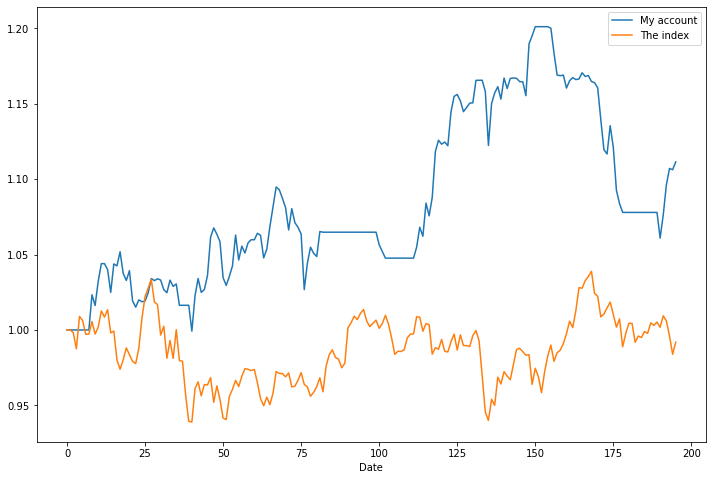

In [122]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min+1]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)